# Stable Diffusion using the Nih dataset (Pytorch backend)

[[paper](https://arxiv.org/abs/2112.10752)][[pytorch code](https://github.com/fastestimator/fastestimator/blob/master/apphub/image_generation/stablediffusion/stablediffusion_torch.py)][[notebook](https://github.com/fastestimator/fastestimator/blob/master/apphub/image_generation/stablediffusion/stablediffusion.ipynb)]

## Introduction to Stable Diffusion

Building on the [DDPM](https://arxiv.org/abs/2006.11239) which applies diffusion on pixel space, [stable diffusion](https://arxiv.org/abs/2112.10752) was developed where diffusion is applied on latent space which is faster and more reliable. Stable diffusion consists of two parts latent embedder and noise estimator network. The latent embedder is normally a variational auto encoder or GAN model  or any auto encoder which is used to extract the latent features from the data set. Noise estimator network would try to learn the noise adding to latent features at various time steps.  Applying DDPM on the latent features instead of directly on pixel values produces images with higher fidelity and is faster. Diffusion pipeline starts with a random noise and applying denoising or noise estimation at each time step iteratively to generate images at the end.

## Import the required libraries

In [ ]:
import math
import tempfile
from tqdm import tqdm
from collections import namedtuple
from typing import Any, Dict

import torch
import torch.nn.functional as F
from torch import nn
from torchvision import models

import fastestimator as fe
from fastestimator.backend._reduce_mean import reduce_mean
from fastestimator.dataset.data import nih_chestxray
from fastestimator.op.numpyop import Delete
from fastestimator.op.numpyop.multivariate import Resize
from fastestimator.op.numpyop.univariate import ChannelTranspose, Normalize, ReadImage
from fastestimator.op.tensorop import TensorOp
from fastestimator.op.tensorop.loss import L1_Loss, LossOp
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.trace.io import BestModelSaver, ModelSaver
from fastestimator.util import BatchDisplay, GridDisplay, ImageDisplay

In [2]:
#training parameters
epochs = 60
batch_size = 8
emb_channels = 16
num_samples = 16
image_size = 256
train_steps_per_epoch = 1000
eval_steps_per_epoch = 200
log_steps = 200
save_dir = tempfile.mkdtemp()
data_dir = None

## Step 1 - Data and `Pipeline` preparation
In this step, we will load NIH chest xray images training and validation dataset and prepare FastEstimator's data `Pipeline`.

### Load dataset 
Let's use a FastEstimator API to load the nih_chestxray dataset: 

In [3]:
train_dataset = nih_chestxray.load_data(root_dir=data_dir)
eval_dataset = train_dataset.split(0.05)

### Set up the preprocessing `Pipline`
In this example, the data preprocessing steps include Reading the image, resizing the image to 256*256 images, normalizing the image pixel values to the range [-1, 1] and transpose the channels. We set up these processing steps using `Ops`, while also defining the data source and batch size for the `Pipeline`.

In [4]:
pipeline = fe.Pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset,
    batch_size=batch_size,
    ops=[
        ReadImage(inputs="x", outputs="image", color_flag='color'),
        Resize(image_in="image", width=image_size, height=image_size),
        Normalize(inputs="image", outputs="image", mean=0.5, std=0.5),
        ChannelTranspose(inputs="image", outputs="image"),
        Delete(keys="x")
    ])


### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize its output. `Pipeline.get_results` will return a batch of data for this purpose:  

In [5]:
data = pipeline.get_results()
data_out = data["image"]*0.5 + 0.5
print("the pipeline output data size: {}".format(data_out.numpy().shape))

the pipeline output data size: (8, 3, 256, 256)


Let's visualize the a image from the `Pipeline` output.

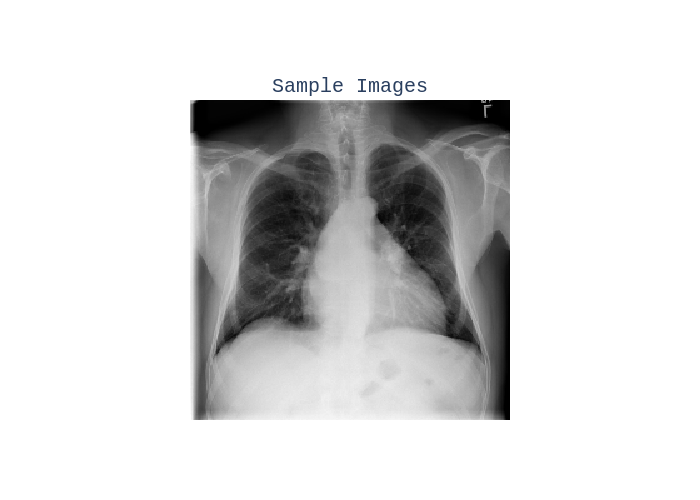

In [38]:
ImageDisplay(image=data_out[0], title="Sample Image").show()

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the Pytorch backend in this example.

### Basic building blocks
Before defining out network lets build some basic functionality used by down the line models.

In [7]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape, generator=None, device=self.parameters.device)
        return x

    def kl(self):
        return 0.5 * torch.mean(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])

    def sample_loss(self):
        return self.sample(), torch.mean(self.kl())


class Upsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1)

    def forward(self, x, emb=None):
        x = torch.nn.functional.interpolate(x, scale_factor=2.0, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=2, padding=0)

    def forward(self, x, emb=None):
        x = torch.nn.functional.pad(x, (0, 1, 0, 1), mode="constant", value=0)
        x = self.conv(x)
        return x


def nonlinearity(x):
    return x * torch.sigmoid(x)  # swish


def get_normalize(in_channels, num_groups=32):
    return torch.nn.GroupNorm(num_groups=num_groups, num_channels=in_channels, eps=1e-6, affine=True)


class ResnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels=None, temb_channels=512):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels if out_channels is None else out_channels
        self.norm1 = get_normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(self.in_channels, self.out_channels, 3, 1, 1)
        if temb_channels > 0:
            self.temb_proj = torch.nn.Linear(temb_channels, self.out_channels)
        self.norm2 = get_normalize(out_channels)
        self.conv2 = torch.nn.Conv2d(self.out_channels, self.out_channels, 3, 1, 1)
        if self.in_channels != self.out_channels:
            self.conv_shortcut = torch.nn.Conv2d(self.in_channels, self.out_channels, 3, 1, 1)

    def forward(self, x, temb=None):
        h = x
        h = self.conv1(nonlinearity(self.norm1(h)))
        if temb is not None:
            h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]
        h = self.conv2(nonlinearity(self.norm2(h)))
        if self.in_channels != self.out_channels:
            x = self.conv_shortcut(x)
        return x + h

### AutoEncoder Model construction
Latent Embedder for a diffison pipeline can any auto encoder model like VAE, VQGAN, VQVAE. But for simplicity purpose lets use a VAE model as a latent embedder. Both of the encoder and decoder definitions are implemented in Pytorch and instantiated by calling `fe.build` (which also associates the model with specific optimizers).

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, emb_channels=4, hid_chs=(64, 128, 256, 512)):
        super().__init__()
        self.in_channels = in_channels
        self.emb_channels = emb_channels
        self.temb_ch = 0
        self.num_resolution = len(hid_chs)
        self.inc = nn.Conv2d(self.in_channels, hid_chs[0], kernel_size=3, stride=1, padding=1)

        self.down = nn.ModuleList()
        block_in = hid_chs[0]
        for i in range(self.num_resolution):
            down = nn.Module()
            block_out = hid_chs[i]
            down.block = nn.ModuleList(
                [ResnetBlock(block_in, block_out, self.temb_ch), ResnetBlock(block_out, block_out, self.temb_ch)])
            block_in = block_out
            if i != self.num_resolution - 1:
                down.downsample = Downsample(block_out)
            self.down.append(down)

        self.mid = nn.ModuleList([
            ResnetBlock(hid_chs[-1], hid_chs[-1], self.temb_ch),
            ResnetBlock(hid_chs[-1], hid_chs[-1], self.temb_ch),
        ])

        # end
        self.norm_out = get_normalize(hid_chs[-1])
        self.conv_out = torch.nn.Conv2d(hid_chs[-1], self.emb_channels, kernel_size=3, stride=1, padding=1)
        self.quant_conv = torch.nn.Conv2d(self.emb_channels, self.emb_channels, 1)
        

    def forward(self, x):
        temb = None

        # downsampling
        h = self.inc(x)
        for i_level in range(self.num_resolution):
            for i in range(2):
                h = self.down[i_level].block[i](h, temb)

            if i_level != self.num_resolution - 1:
                h = self.down[i_level].downsample(h)

        # middle
        h = self.mid[0](h, temb)
        h = self.mid[1](h, temb)

        # end
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior.sample_loss()


class Decoder(nn.Module):
    def __init__(self, emb_channels, out_channels=3, hid_chs=(64, 128, 256, 512)):
        super().__init__()
        self.post_quant_conv = torch.nn.Conv2d(emb_channels, emb_channels, 1)
        self.emb_channels = emb_channels
        self.out_channels = out_channels
        self.temb_ch = 0
        self.num_resolutions = len(hid_chs)
        self.inc = nn.Conv2d(self.emb_channels, hid_chs[-1], kernel_size=3, stride=1, padding=1)

        # middle
        self.mid = nn.ModuleList(
            [ResnetBlock(hid_chs[-1], hid_chs[-1], self.temb_ch), ResnetBlock(hid_chs[-1], hid_chs[-1], self.temb_ch)])

        self.up = nn.ModuleList()
        block_in = hid_chs[-1]
        for i_level in reversed(range(self.num_resolutions)):
            up = nn.Module()
            block_out = hid_chs[i_level]
            up.block = nn.ModuleList([
                ResnetBlock(block_in, block_out, self.temb_ch),
                ResnetBlock(block_out, block_out, self.temb_ch),
                ResnetBlock(block_out, block_out, self.temb_ch)
            ])
            block_in = block_out
            if i_level != 0:
                up.upsample = Upsample(block_in)
            self.up.append(up)

        # end
        self.norm_out = get_normalize(block_in)
        self.conv_out = torch.nn.Conv2d(block_in, self.out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        temb = None
        x = self.post_quant_conv(x)
        
        # downsampling
        h = self.inc(x)
        
        # middle
        h = self.mid[0](h, temb)
        h = self.mid[1](h, temb)
        for i_level in range(self.num_resolutions):
            for i_block in range(3):
                h = self.up[i_level].block[i_block](h, temb)
            if i_level != self.num_resolutions - 1:
                h = self.up[i_level].upsample(h)
        h = self.norm_out(h)
        h = nonlinearity(h)
        h = self.conv_out(h)
        return h

In [9]:
encoder_model = fe.build(model_fn=lambda:Encoder(in_channels=3, emb_channels=2*emb_channels), optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4),  model_name="encoder")
decoder_model = fe.build(model_fn=lambda:Decoder(emb_channels=emb_channels, out_channels=3), optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-4),  model_name="decoder")

### Customize `Ops` 
`Ops` are the basic components of a `Network`. They can be logic for loss calculation, model update units, or even the model itself. Some `Ops` such as cross entropy are pre-defined in FastEstimator, but for any logic that is not there yet, users need to define their own `Ops`. **Please keep all custom `Ops` backend-consistent with your model backend**. In this case all `Ops` need to be implemented in TensorFlow since our model is built from Tensorflow.      

Recently, as introduced by the [**paper**](https://arxiv.org/pdf/1801.03924.pdf) the features of the VGG network trained on ImageNet classification has been remarkably useful for image synthesis. LPIPS essentially computes the similarity between the activations of two image patches for some pre-defined network. This measure has been shown to match human perception well. A low LPIPS score means that image patches are perceptual similar. Lets define LPIPS loss which uses the LPIPS score.

In [10]:
class LPIPS_Loss(LossOp):
    def __init__(self, inputs, outputs, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.net = VGG16(requires_grad=False)
        self.chns = (64,128,256,512,512)
        self.L = len(self.chns)
        self.net.eval()
        self.shift = torch.Tensor([-.030, -.088, -.188])[None,:, None, None]
        self.scale = torch.Tensor([.458, .448, .450])[None,:, None, None]
        self.net = self.net.to('cuda')
        self.shift = self.shift.to('cuda')
        self.scale = self.scale.to('cuda')

    def normalize_tensor(self, in_feat, eps=1e-10):
        norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
        return in_feat/(norm_factor+eps)

    def spatial_average(self, in_tens, keepdim=True):
        return in_tens.mean([2,3], keepdim=keepdim)

    def scaling_layer(self, in_tens):
        return (in_tens - self.shift) / self.scale

    def forward(self, data, state: Dict[str, Any]):
        in0, in1 = data
        in0_input, in1_input = self.scaling_layer(in0), self.scaling_layer(in1)
        outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
        feats0, feats1, diffs = {}, {}, {}

        for kk in range(self.L):
            feats0[kk], feats1[kk] = self.normalize_tensor(outs0[kk]), self.normalize_tensor(outs1[kk])
            diffs[kk] = (feats0[kk]-feats1[kk])**2

        res = [self.spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True) for kk in range(self.L)]

        val = 0
        for l in range(self.L):
            val += res[l]
        return reduce_mean(val)


class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        vgg_pretrained_features = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out

In [11]:
class WeightedLoss(TensorOp):
    def __init__(self, inputs, outputs, p_loss_weight=1.0, l1_loss_weights=1, embedding_loss_weight=1e-6):
        super().__init__(inputs=inputs, outputs=outputs)
        self.embedding_loss_weight = embedding_loss_weight
        self.p_loss_weight = p_loss_weight
        self.l1_loss_weights = l1_loss_weights

    def forward(self, data, state: Dict[str, Any]):
        l1_loss, p_loss, emb_loss  = data
        loss = l1_loss * self.l1_loss_weights + p_loss * self.p_loss_weight + emb_loss * self.embedding_loss_weight
        return loss

### `Network` definition
We are going to connect all models and `Ops` together into a `Network` 

In [13]:
network = fe.Network(ops=[
    ModelOp(model=encoder_model, inputs="image", outputs=['sample', 'emb_loss']),
    ModelOp(model=decoder_model, inputs="sample", outputs='pred'),
    L1_Loss(inputs=['pred', 'image'], outputs='l1_loss'),
    LPIPS_Loss(inputs=['pred', 'image'], outputs='p_loss'),
    WeightedLoss(inputs=['l1_loss', 'p_loss', 'emb_loss'], outputs='loss'),
    UpdateOp(model=decoder_model, loss_name="loss"),
    UpdateOp(model=encoder_model, loss_name="loss")
])


## Step 3 - `Estimator` definition and training autoencoder
In this step, we define the `Estimator` to compile the `Network` and `Pipeline` and indicate in `traces` that we want to save the best models. We can then use `estimator.fit()` to start the training process:

In [14]:
traces = [BestModelSaver(model=encoder_model, save_dir=save_dir, metric="p_loss"),
          BestModelSaver(model=decoder_model, save_dir=save_dir, metric="p_loss")]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         monitor_names=["l1_loss", "p_loss", "emb_loss", 'loss'],
                         epochs=epochs//4,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch,
                         log_steps=log_steps)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 200; num_device: 1;
FastEstimator-Train: step: 1; emb_loss: 0.038033076; l1_loss: 0.49019524; loss: 8.856004; p_loss: 8.3658085;
FastEstimator-Train: step: 200; emb_loss: 4.6701; l1_loss: 0.06875328; loss: 3.4815755; p_loss: 3.4128175; steps/sec: 3.42;
FastEstimator-Train: step: 400; emb_loss: 6.000989; l1_loss: 0.049630992; loss: 2.7225912; p_loss: 2.6729543; steps/sec: 3.4;
FastEstimator-Train: step: 600; emb_loss: 7.0360165; l1_loss: 0.04015334; loss: 2.186053; p_loss: 2.1458926; steps/sec: 3.4;
FastEstim

## Latent embedder inferencing

Great we are half way through. Since the latent embedder is trained, lets try to run encoder and decoder to view some of the generated images:

In [15]:
network = fe.Network(ops=[ModelOp(model=encoder_model, inputs="image", outputs=['sample', 'loss'], mode='infer', trainable=False, gradients=False), 
                         ModelOp(model=decoder_model, inputs="sample", outputs='pred', mode='infer', trainable=False, gradients=False)])
infer_data = network.transform(data, mode="infer")

In [16]:
# lets denormalize the input images and prediction output
pred_data = (infer_data['pred']*0.5 + 0.5).clip(0, 1)
input_data = (infer_data['image']*0.5 + 0.5).clip(0, 1)

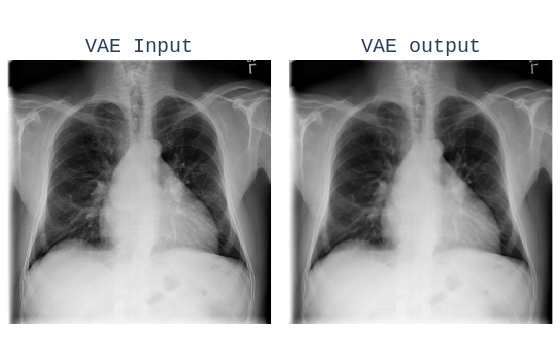

In [34]:
GridDisplay([BatchDisplay(image=input_data[:1], title="VAE Input"), BatchDisplay(image=pred_data[:1], title="VAE output")]).show()

Instead of iteratively adding the noise to the given latent embedding based on the time step, noise scheduler adds gaussian noise to the input image at any given time step in a single step. For more information about the math behind the how this is applied, please refer to this [paper](https://arxiv.org/pdf/2208.11970.pdf).

In [18]:
class GaussianNoiseScheduler():

    def __init__(
        self,
        timesteps=1000,
        T=None,
        beta_start=0.002,  # default 1e-4, stable-diffusion ~ 1e-3
        beta_end=0.02,
        betas=None,
        device='cuda'
    ):
        super().__init__()
        self.device = device
        self.timesteps = timesteps
        self.T = timesteps if T is None else T

        self.timesteps_array = torch.linspace(0, self.T - 1, self.timesteps, dtype=torch.long, device=self.device)
        # NOTE: End is inclusive therefore use -1 to get [0, T-1]
        # scaled_linear  # proposed as "quadratic" in https://arxiv.org/abs/2006.11239, used in stable-diffusion
        betas = torch.linspace(beta_start**0.5, beta_end**0.5, timesteps, dtype=torch.float64, device=self.device)**2
        alphas = 1 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.)

        self.betas = betas.to(torch.float32)  # (0 , 1)
        self.alphas = alphas.to(torch.float32)
        self.alphas_cumprod = alphas_cumprod.to(torch.float32)

        self.alphas_cumprod_prev = alphas_cumprod_prev
        self.sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1. / alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1. / alphas_cumprod - 1)

        self.posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
        self.posterior_mean_coef2 = (1. - alphas_cumprod_prev) * torch.sqrt(alphas) / (1. - alphas_cumprod)
        self.posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    def estimate_x_t(self, x_0, t, x_T=None):
        # NOTE: t == 0 means diffused for 1 step (https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils.py#L108)
        x_T = self.x_final(x_0) if x_T is None else x_T 

        def clipper(b):
            tb = t[b]
            if tb<0:
                return x_0[b]
            elif tb>=self.T:
                return x_T[b] 
            else:
                return self.sqrt_alphas_cumprod[tb]*x_0[b]+self.sqrt_one_minus_alphas_cumprod[tb]*x_T[b]
        x_t = torch.stack([clipper(b) for b in range(t.shape[0])]) 
        return x_t 
    
    def estimate_x_t_prior_from_x_T(self, x_t, t, x_T, use_log=True, var_scale=0): 
        x_0 = self.estimate_x_0(x_t, x_T, t)
        return self.estimate_x_t_prior_from_x_0(x_t, t, x_0, use_log, var_scale)


    def estimate_x_t_prior_from_x_0(self, x_t, t, x_0, use_log=True, var_scale=0):
        mean = self.estimate_mean_t(x_t, x_0, t)
        variance = self.estimate_variance_t(t, x_t.ndim, use_log, var_scale)
        std = torch.exp(0.5*variance) if use_log else torch.sqrt(variance)
        std[t==0] = 0.0 
        x_T = self.x_final(x_t)
        x_t_prior =  mean+std*x_T
        return x_t_prior, x_0 

    def estimate_mean_t(self, x_t, x_0, t):
        ndim = x_t.ndim
        return (self.extract(self.posterior_mean_coef1, t, ndim)*x_0 + self.extract(self.posterior_mean_coef2, t, ndim)*x_t) 
    
    def sample(self, x_0):
        """Randomly sample t from [0,T] and return x_t and x_T based on x_0"""
        t = torch.randint(0, self.T, (x_0.shape[0],), dtype=torch.long, device=x_0.device) # NOTE: High is exclusive, therefore [0, T-1]
        x_T = self.x_final(x_0) 
        return self.estimate_x_t(x_0, t, x_T), x_T, t

    def estimate_variance_t(self, t, ndim, log=True, var_scale=0, eps=1e-20):
        min_variance = self.extract(self.posterior_variance, t, ndim)
        max_variance = self.extract(self.betas, t, ndim)
        if log:
            min_variance = torch.log(min_variance.clamp(min=eps))
            max_variance = torch.log(max_variance.clamp(min=eps))
        return var_scale * max_variance + (1 - var_scale) * min_variance 

    def estimate_x_0(self, x_t, x_T, t):
        ndim = x_t.ndim
        x_0 = (self.extract(self.sqrt_recip_alphas_cumprod, t, ndim)*x_t - 
                self.extract(self.sqrt_recipm1_alphas_cumprod, t, ndim)*x_T)
        return x_0

    def estimate_x_T(self, x_t, x_0, t):
        ndim = x_t.ndim
        return ((self.extract(self.sqrt_recip_alphas_cumprod, t, ndim)*x_t - x_0)/ 
                self.extract(self.sqrt_recipm1_alphas_cumprod, t, ndim))
    
    @classmethod
    def x_final(cls, x):
        return torch.randn_like(x)

    @classmethod
    def _clip_x_0(cls, x_0):
        # See "static/dynamic thresholding" in Imagen https://arxiv.org/abs/2205.11487 
        m = 1 # Set this to about 4*sigma = 4 if latent diffusion is used  
        x_0 = x_0.clamp(-m, m)
        return x_0
    
    @staticmethod 
    def extract(x, t, ndim):
        """Extract values from x at t and reshape them to n-dim tensor"""
        x = x.to(t.device)
        return x.gather(0, t).reshape(-1, *((1,)*(ndim-1))) 

### Noise Estimator Model construction

Since we have already built latent embedder to produce the latent vectors, let build noise estimator which is similar to Unet with additional time embeddings model to estimate the noise in the latent space at any given time step.

In [19]:
class SequentialEmb(nn.Sequential):
    def forward(self, input_data, emb):
        for layer in self:
            if isinstance(layer, ResnetBlock):
                input_data = layer(input_data, emb)
            else:
                input_data = layer(input_data)
        return input_data

def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class NoiseNetwork(nn.Module):
    def __init__(self, in_ch=1, out_ch=1, hid_chs=(256, 256, 512, 1024), emb_dim=4):
        super().__init__()
        self.depth = len(hid_chs)

        self.in_blocks = nn.ModuleList()

        # ----------- In-Convolution ------------
        self.in_blocks.append(nn.Conv2d(in_ch, hid_chs[0], kernel_size=3, stride=1, padding=1))

        # -------------- Encoder ----------------
        for i in range(1, self.depth):
            self.in_blocks.append(SequentialEmb(ResnetBlock(hid_chs[i-1], hid_chs[i], emb_dim)))
            self.in_blocks.append(SequentialEmb(ResnetBlock(hid_chs[i], hid_chs[i], emb_dim)))
            if i < self.depth - 1:
                self.in_blocks.append(SequentialEmb(Downsample(hid_chs[i])))

        # ----------- Middle ------------
        self.middle_block = SequentialEmb(
            ResnetBlock(in_channels=hid_chs[-1], out_channels=hid_chs[-1], temb_channels=emb_dim),
            ResnetBlock(in_channels=hid_chs[-1], out_channels=hid_chs[-1], temb_channels=emb_dim))

        # ------------ Decoder ----------
        out_blocks = []
        for i in range(1, self.depth):
            for k in range(3):
                seq_list = []
                hidd_channels = hid_chs[i-1 if k==0 else i]
                seq_list.append(ResnetBlock(hid_chs[i] + hidd_channels, out_channels=hidd_channels, temb_channels=emb_dim))
                if i > 1 and k == 0:
                    seq_list.append(Upsample(hidd_channels))
                out_blocks.append(SequentialEmb(*seq_list))
        self.out_blocks = nn.ModuleList(out_blocks)

        # --------------- Out-Convolution ----------------
        self.outc = zero_module(nn.Sequential(nn.Conv2d(hid_chs[0], out_ch, 3, padding=1)))

        self.emb_dim = emb_dim
        self.pos_emb_dim = emb_dim // 4
        self.time_emb = nn.Sequential(
            nn.Linear(self.pos_emb_dim, self.emb_dim),
            nn.SiLU(),
            nn.Linear(self.emb_dim, self.emb_dim))

    def get_sinusoidal_pos_emb(self, time, max_period=10000, downscale_freq_shift=1):
        device = time.device
        half_dim = self.pos_emb_dim // 2
        emb = math.log(max_period) / (half_dim - downscale_freq_shift)
        emb = torch.exp(-emb * torch.arange(half_dim, device=device))
        emb = time[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

    def forward(self, x, t):

        emb = None
        if t is not None:
            sinusoidal_emd = self.get_sinusoidal_pos_emb(t)
            emb = self.time_emb(sinusoidal_emd)

        x_input_block = []
        # --------- Encoder --------------
        for i, module in enumerate(self.in_blocks):
            if i == 0:
                x = module(x)
            else:
                x = module(x, emb)
            x_input_block.append(x)

        # ---------- Middle --------------
        x = self.middle_block(x, emb)

        # -------- Decoder -----------
        for i in range(len(self.out_blocks), 0, -1):
            if isinstance(self.out_blocks[i-1], SequentialEmb):
                x = torch.cat([x, x_input_block.pop()], dim=1)
                x = self.out_blocks[i-1](x, emb)
            else:
                x = self.out_blocks[i-1](x)
        return self.outc(x)

# Noise Model

Lets build a noise network model to estimate noise at a given point of time

In [20]:
noise_model = fe.build(
    model_fn=lambda: NoiseNetwork(in_ch=emb_channels, out_ch=emb_channels, hid_chs=[256, 256, 512, 1024], emb_dim=1024),
    optimizer_fn=lambda x: torch.optim.Adam(x, lr=1e-5),
    model_name="noise_model")


# Noise Sampler

We need to train a model which can predict noise any a given point of time in the given time steps range. Lets define a noise sampler which will generate random time stamps with the provided time steps and generate encoded image along with image at previous step.

In [22]:
class NoiseSampler(TensorOp):
    def __init__(self, inputs, outputs):
        super().__init__(inputs=inputs, outputs=outputs)
        self.gausian_noise_scheduler = GaussianNoiseScheduler()

    def forward(self, data, state: Dict[str, Any]):
        encoded_image = data
        with torch.no_grad():
            encoded_image_t, encoded_image_T, t = self.gausian_noise_scheduler.sample(encoded_image)
        return encoded_image_t, encoded_image_T, t

### Noise Estimator `Network` definition
We are going to connect encoder with noise network and `Ops` together into a `Network` 

In [23]:
network = fe.Network(ops=[
    ModelOp(model=encoder_model, inputs="image", outputs=['sample', 'embedded_loss'], trainable=False, gradients=False),
    NoiseSampler(inputs='sample', outputs=['encoded_image_t', 'encoded_image_T', 't']),
    ModelOp(model=noise_model, inputs=["encoded_image_t", 't'], outputs='pred'),
    L1_Loss(inputs=['pred', 'encoded_image_T'], outputs='l1_loss'),
    UpdateOp(model=noise_model, loss_name="l1_loss")
])

In [ ]:
traces = [ModelSaver(model=noise_model, save_dir=save_dir, frequency=4)]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         eval_steps_per_epoch=eval_steps_per_epoch,
                         log_steps=log_steps)

estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; logging_interval: 200; num_device: 1;
FastEstimator-Train: step: 1; l1_loss: 0.7983067;
FastEstimator-Train: step: 200; l1_loss: 0.5881994; steps/sec: 12.43;
FastEstimator-Train: step: 400; l1_loss: 0.30263466; steps/sec: 12.39;
FastEstimator-Train: step: 600; l1_loss: 0.37248456; steps/sec: 12.33;
FastEstimator-Train: step: 800; l1_loss: 0.43146664; steps/sec: 12.36;
FastEstimator-Train: step: 1000; l1_loss: 0.29425317; steps/sec: 12.33;
FastEstimator-Train: step: 1000; epoch: 1; epoch_time(sec): 86.23;
Eval Progress: 1/200;

# Congratulations we have successfully trained a diffusion model

Since the heavy lifting is already done, lets begin the fun part and generate random images using the noise model.

Lets create a diffusion pipeline which takes the noise network and the decoder, to generate new images. Diffusion pipeline starts with from noise and iteratively removes noise using the noise estimator and at the end of this iterative process it produces the new images

In [23]:
class DiffusionInferencePipeline():
    def __init__(self, noise_network, decoder_model):
        super().__init__()
        self.noise_scheduler = GaussianNoiseScheduler()
        self.noise_network = noise_network
        self.latent_decoder = decoder_model
        with torch.no_grad():
            for param in self.latent_decoder.parameters():
                param.requires_grad = False
            for param in self.noise_network.parameters():
                param.requires_grad = False
        self.latent_decoder.eval()
        self.noise_network.eval()
        self.latent_decoder.to('cuda')
        self.noise_network.to('cuda')

    @torch.no_grad()
    def noise_estimate(self, x_t, t, condition=None):
        # Note: x_t expected to be in range ~ [-1, 1]
        pred = self.noise_network(x_t, t)
        x_t_prior, x_0 = self.noise_scheduler.estimate_x_t_prior_from_x_T(x_t, t, pred, var_scale=False)
        x_T = pred

        return x_t_prior, x_0, x_T

    @torch.no_grad()
    def denoise(self, x_t, steps=1000, **kwargs):
        # ---------- run denoise loop ---------------
        timesteps_array = self.noise_scheduler.timesteps_array[slice(0, steps)] # [0, ...,T-1] (target time not time of x_t)

        for i, t in tqdm(enumerate(reversed(timesteps_array))):
            # noise network prediction
            self.noise_network.eval()
            with torch.no_grad():
                x_t, _, _ = self.noise_estimate(x_t, t.expand(x_t.shape[0]))
            x_t = x_t.to(torch.float32)

        # ------ Eventually decode from latent space into image space--------
        if self.latent_decoder is not None:
            self.latent_decoder.eval()
            with torch.no_grad():
                x_t = self.latent_decoder(x_t)
        return x_t

    @torch.no_grad()
    def sample(self, num_samples, img_size, **kwargs):
        self.device = 'cuda'
        template = torch.zeros((num_samples, *img_size), device=self.device)
        x_T = self.noise_scheduler.x_final(template)
        x_0 = self.denoise(x_T, **kwargs)
        return x_0

## Loading the diffusion pipeline using the pretrained noise estimator and the decoder

In [27]:
diffusion_pipeline = DiffusionInferencePipeline(noise_model, decoder_model)

In [30]:
diffusion_sample = (emb_channels, image_size//8, image_size//8) # similar to the output of latent embedder
sample_image_batch = diffusion_pipeline.sample(num_samples, diffusion_sample)
sample_image_batch = sample_image_batch*0.5 + 0.5
sample_image_batch = sample_image_batch.clamp(0, 1)

1000it [00:19, 50.80it/s]


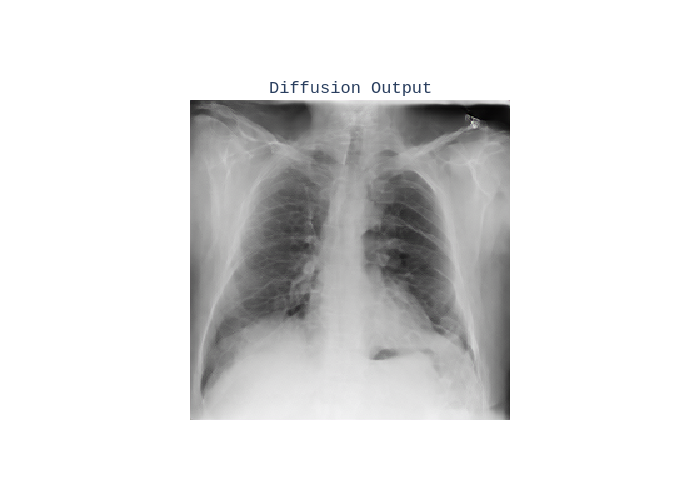

In [40]:
ImageDisplay(image=sample_image_batch[0].cpu(), title="Diffusion Output").show()

Bravo, in less than 3 hr we are able to produce decent 256*256 chest xray images using stable diffusion. Based on the results at each step increase the training epochs for either training the noise network or latent embedder.